In [7]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from gs_quant.markets.portfolio import Portfolio
from gs_quant.risk import MarketDataShockBasedScenario, MarketDataPattern, MarketDataShock, MarketDataShockType, PnlExplain
from gs_quant.markets import PricingContext
plt.rcParams['figure.figsize'] = (16, 8)

In [8]:
from gs_quant.session import GsSession
# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics', 'read_product_data'))

In this notebook, we'll load a portfolio and run analytics to understand it's risk and pnl. We'll also run a number of vol and spot scenarios which we'll use to compute VaR.

The content of this notebook is split into the following parts:
* [1: First, the portfolio](#1:-First,-the-portfolio)
* [2: Run risk and PnL explain](#2:-Run-risk-and-PnL-explain)
* [3: Scenarios grid and VaR](#3:-Scenarios-grid-and-VaR)

### 1: First, the portfolio

Let’s first load a portfolio from csv, mapping each column and look at it as a dataframe. Internal users can load this books directly using `from book`.

In [9]:
mappers = {
    'pair': lambda row: row['foreign ccy'] + 'USD',
    'notional_amount': 'notional',
    'expiration_date': 'expiry',
    'option_type': lambda row: 'Call' if row['C/P'] == 'C' else 'Put',
    'strike_price': 'strike',
    'premium': lambda row: 0
}
portfolio = Portfolio.from_csv(r'FXBook.csv', mappings=mappers)
portfolio.resolve()
frame = portfolio.to_frame()
frame.index = frame.index.droplevel(0)
frame.head(1).transpose()

# for internal users:
# portfolio = Portfolio.from_book('my_book_id')

instrument,<gs_quant.target.instrument.FXOption object at 0x0000000019252518>
asset_class,AssetClass.FX
type,AssetType.Option
buy_sell,BuySell.Buy
call_amount,25000000
call_currency,Currency.AUD
expiration_date,2020-10-21
expiration_time,NYC
method_of_settlement,OptionSettlementMethod.Physical
notional_amount,2.5e+07
option_type,OptionType.Call


### 2: Run risk and PnL explain

With the portfolio in hand, let’s use gs-quant to understand risk and pnl over the last business day.

In [10]:
from gs_quant.datetime.date import business_day_offset
from gs_quant.markets import CloseMarket, PricingContext, close_market_date
from gs_quant.risk import Price, DollarPrice, PnlExplain, Theta, FXDelta, FXGamma, FXVega

to_date = business_day_offset(close_market_date(), -1)

# Previous business day
from_date = business_day_offset(to_date, -1)

# A risk measure for calculating PnlExplain from that date
explain = PnlExplain(CloseMarket(date=to_date))

# Calculate PnlExplain and dollar price from 1 day ago
with PricingContext(pricing_date=from_date):
    result = portfolio.calc((FXDelta, FXGamma, FXVega, DollarPrice, Theta, explain))
    
# Calculate dollar price with today's market
with PricingContext(pricing_date=to_date):
    target_price = portfolio.calc((DollarPrice))

with PricingContext(pricing_date=from_date, market=CloseMarket(date=to_date)):
    target_price_ex_theta = portfolio.calc((DollarPrice))

In [11]:
print('Risk and 1day Pnl as of '+str(from_date))
print(f'Book PV (in mUSD): {target_price[DollarPrice].aggregate()/1e6:.1f}')
print(f'Book Delta (in mUSD): {result[FXDelta].aggregate().value.sum()/1e6:.0f}')
print(f'Book Vega (in kUSD): {result[FXVega].aggregate().value.sum():.0f}')
print(f'Dollar price day on day change (in kUSD): {target_price[DollarPrice].aggregate()/1e3 - result[DollarPrice].aggregate()/1e3:.0f}')
print(f'Dollar price day on day change(ex theta) (in kUSD): {target_price_ex_theta[DollarPrice].aggregate()/1e3 - result[DollarPrice].aggregate()/1e3:.0f}')
print(f'Pnl explain total (in kUSD): {result[explain].aggregate().value.sum()/1e3:.0f}')
print(f'Theta total (in kUSD): {result[Theta].aggregate().value.sum()/1e3:.0f}')
print(f'Theta + Pnl explain total (in kUSD): {result[Theta].aggregate().value.sum()/1e3 + result[explain].aggregate().value.sum()/1e3:.0f}')

# Show the PnlExplain breakdown
explain_all = result[explain].aggregate()
explain_all[explain_all.value.abs() > 1.0].round(0)

Risk and 1day Pnl as of 2020-09-04
Book PV (in mUSD): 15.8
Book Delta (in mUSD): 186
Book Vega (in kUSD): 1390
Dollar price day on day change (in kUSD): 770
Dollar price day on day change(ex theta) (in kUSD): 799
Pnl explain total (in kUSD): 799
Theta total (in kUSD): -61
Theta + Pnl explain total (in kUSD): 738


,mkt_type,mkt_asset,value
0,FX,USD/AUD,775947.0
3,FX EVENTS,USD,-12.0
4,FX FWD,USD/AUD,1419.0
5,FX VOL,USD/AUD,58135.0
6,IR,AUD,-50239.0
7,IR BASIS,AUD OIS/AUD-3M,35.0
8,IR BASIS,AUD-3M/AUD-6M,2843.0
11,IR XC,AUD,11020.0


### 3: Scenarios grid and VaR

We can also better understand risk by applying a number of market shocks – in this case we’ll look at a grid of vol and spot shocks, we are can also use to calculate VaR by looking at the 95% percentile price change.

In [13]:
shocks_fx = [-10, -7.5, -5, -2,-1, 0, 1, 2, 5, 7.5, 10]
shocks_vols = [-5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 7.5, 10]
shocked_prices = pd.DataFrame(index=shocks_vols, columns=shocks_fx)

cross = explain_all[explain_all['mkt_type'] == 'FX']['mkt_asset'][0]

with PricingContext(is_async=True):
    for fx in shocks_fx:
        for vol in shocks_vols:
            with MarketDataShockBasedScenario({
                MarketDataPattern('FX', cross): MarketDataShock(MarketDataShockType.Proportional, fx / 1e2),
                MarketDataPattern('FX Vol', cross, 'ATM Vol'): MarketDataShock(MarketDataShockType.Absolute, vol / 1e2),
            }):
                shocked_prices[fx][vol] = portfolio.calc((DollarPrice))

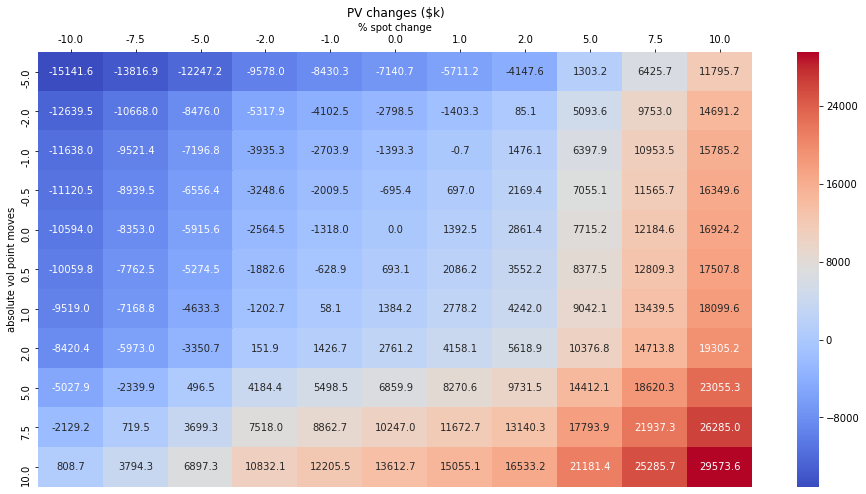

In [15]:
# Aggregate and compute pnl by substracting 0 shock PV
shocked_prices_res = pd.DataFrame(index=shocks_vols, columns=shocks_fx, dtype='float')

for fx in shocks_fx:
    for vol in shocks_vols:
        shocked_prices_res[fx][vol] = shocked_prices[fx][vol].aggregate()
        
shocked_prices_res -= shocked_prices[0][0].aggregate()
shocked_prices_res /= 1e3

ax = sns.heatmap(shocked_prices_res, cmap='coolwarm', annot=True, fmt='.1f')
ax.set(ylabel='absolute vol point moves', xlabel='% spot change', title='PV changes ($k)')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

Compute VaR

In [16]:
p = np.percentile(shocked_prices_res, 5)  # return 95th percentile
print('Portfolio base price ($m):   {:,.1f}'.format(portfolio.price().aggregate()/1e6))
print('Scenario Based VaR with spot/vol grid ($m): {:,.1f}'.format(p/1e3))

Portfolio base price ($m):   15.2
Scenario Based VaR with spot/vol grid ($m): -10.7


### Disclaimers

Scenarios/predictions: Simulated results are for illustrative purposes only. GS provides no assurance or guarantee that the strategy will operate or would have operated in the past in a manner consistent with the above analysis. Past performance figures are not a reliable indicator of future results.

Indicative Terms/Pricing Levels: This material may contain indicative terms only, including but not limited to pricing levels. There is no representation that any transaction can or could have been effected at such terms or prices. Proposed terms and conditions are for discussion purposes only. Finalized terms and conditions are subject to further discussion and negotiation.
www.goldmansachs.com/disclaimer/sales-and-trading-invest-rec-disclosures.html If you are not accessing this material via Marquee ContentStream, a list of the author's investment recommendations disseminated during the preceding 12 months and the proportion of the author's recommendations that are 'buy', 'hold', 'sell' or other over the previous 12 months is available by logging into Marquee ContentStream using the link below. Alternatively, if you do not have access to Marquee ContentStream, please contact your usual GS representative who will be able to provide this information to you.

Backtesting, Simulated Results, Sensitivity/Scenario Analysis or Spreadsheet Calculator or Model: There may be data presented herein that is solely for illustrative purposes and which may include among other things back testing, simulated results and scenario analyses. The information is based upon certain factors, assumptions and historical information that Goldman Sachs may in its discretion have considered appropriate, however, Goldman Sachs provides no assurance or guarantee that this product will operate or would have operated in the past in a manner consistent with these assumptions. In the event any of the assumptions used do not prove to be true, results are likely to vary materially from the examples shown herein. Additionally, the results may not reflect material economic and market factors, such as liquidity, transaction costs and other expenses which could reduce potential return.

OTC Derivatives Risk Disclosures: 
Terms of the Transaction: To understand clearly the terms and conditions of any OTC derivative transaction you may enter into, you should carefully review the Master Agreement, including any related schedules, credit support documents, addenda and exhibits. You should not enter into OTC derivative transactions unless you understand the terms of the transaction you are entering into as well as the nature and extent of your risk exposure. You should also be satisfied that the OTC derivative transaction is appropriate for you in light of your circumstances and financial condition. You may be requested to post margin or collateral to support written OTC derivatives at levels consistent with the internal policies of Goldman Sachs. 
 
Liquidity Risk: There is no public market for OTC derivative transactions and, therefore, it may be difficult or impossible to liquidate an existing position on favorable terms. Transfer Restrictions: OTC derivative transactions entered into with one or more affiliates of The Goldman Sachs Group, Inc. (Goldman Sachs) cannot be assigned or otherwise transferred without its prior written consent and, therefore, it may be impossible for you to transfer any OTC derivative transaction to a third party. 
 
Conflict of Interests: Goldman Sachs may from time to time be an active participant on both sides of the market for the underlying securities, commodities, futures, options or any other derivative or instrument identical or related to those mentioned herein (together, "the Product"). Goldman Sachs at any time may have long or short positions in, or buy and sell Products (on a principal basis or otherwise) identical or related to those mentioned herein. Goldman Sachs hedging and trading activities may affect the value of the Products. 
 
Counterparty Credit Risk: Because Goldman Sachs, may be obligated to make substantial payments to you as a condition of an OTC derivative transaction, you must evaluate the credit risk of doing business with Goldman Sachs or its affiliates. 
 
Pricing and Valuation: The price of each OTC derivative transaction is individually negotiated between Goldman Sachs and each counterparty and Goldman Sachs does not represent or warrant that the prices for which it offers OTC derivative transactions are the best prices available, possibly making it difficult for you to establish what is a fair price for a particular OTC derivative transaction; The value or quoted price of the Product at any time, however, will reflect many factors and cannot be predicted. If Goldman Sachs makes a market in the offered Product, the price quoted by Goldman Sachs would reflect any changes in market conditions and other relevant factors, and the quoted price (and the value of the Product that Goldman Sachs will use for account statements or otherwise) could be higher or lower than the original price, and may be higher or lower than the value of the Product as determined by reference to pricing models used by Goldman Sachs. If at any time a third party dealer quotes a price to purchase the Product or otherwise values the Product, that price may be significantly different (higher or lower) than any price quoted by Goldman Sachs. Furthermore, if you sell the Product, you will likely be charged a commission for secondary market transactions, or the price will likely reflect a dealer discount. Goldman Sachs may conduct market making activities in the Product. To the extent Goldman Sachs makes a market, any price quoted for the OTC derivative transactions, Goldman Sachs may differ significantly from (i) their value determined by reference to Goldman Sachs pricing models and (ii) any price quoted by a third party. The market price of the OTC derivative transaction may be influenced by many unpredictable factors, including economic conditions, the creditworthiness of Goldman Sachs, the value of any underlyers, and certain actions taken by Goldman Sachs. 
 
Market Making, Investing and Lending: Goldman Sachs engages in market making, investing and lending businesses for its own account and the accounts of its affiliates in the same or similar instruments underlying OTC derivative transactions (including such trading as Goldman Sachs deems appropriate in its sole discretion to hedge its market risk in any OTC derivative transaction whether between Goldman Sachs and you or with third parties) and such trading may affect the value of an OTC derivative transaction. 
 
Early Termination Payments: The provisions of an OTC Derivative Transaction may allow for early termination and, in such cases, either you or Goldman Sachs may be required to make a potentially significant termination payment depending upon whether the OTC Derivative Transaction is in-the-money to Goldman Sachs or you at the time of termination. Indexes: Goldman Sachs does not warrant, and takes no responsibility for, the structure, method of computation or publication of any currency exchange rates, interest rates, indexes of such rates, or credit, equity or other indexes, unless Goldman Sachs specifically advises you otherwise.
Risk Disclosure Regarding futures, options, equity swaps, and other derivatives as well as non-investment-grade securities and ADRs: Please ensure that you have read and understood the current options, futures and security futures disclosure document before entering into any such transactions. Current United States listed options, futures and security futures disclosure documents are available from our sales representatives or at http://www.theocc.com/components/docs/riskstoc.pdf,  http://www.goldmansachs.com/disclosures/risk-disclosure-for-futures.pdf and https://www.nfa.futures.org/investors/investor-resources/files/security-futures-disclosure.pdf, respectively. Certain transactions - including those involving futures, options, equity swaps, and other derivatives as well as non-investment-grade securities - give rise to substantial risk and are not available to nor suitable for all investors. If you have any questions about whether you are eligible to enter into these transactions with Goldman Sachs, please contact your sales representative. Foreign-currency-denominated securities are subject to fluctuations in exchange rates that could have an adverse effect on the value or price of, or income derived from, the investment. In addition, investors in securities such as ADRs, the values of which are influenced by foreign currencies, effectively assume currency risk.
Options Risk Disclosures: Options may trade at a value other than that which may be inferred from the current levels of interest rates, dividends (if applicable) and the underlier due to other factors including, but not limited to, expectations of future levels of interest rates, future levels of dividends and the volatility of the underlier at any time prior to maturity. Note: Options involve risk and are not suitable for all investors. Please ensure that you have read and understood the current options disclosure document before entering into any standardized options transactions. United States listed options disclosure documents are available from our sales representatives or at http://theocc.com/publications/risks/riskstoc.pdf. A secondary market may not be available for all options. Transaction costs may be a significant factor in option strategies calling for multiple purchases and sales of options, such as spreads. When purchasing long options an investor may lose their entire investment and when selling uncovered options the risk is potentially unlimited. Supporting documentation for any comparisons, recommendations, statistics, technical data, or other similar information will be supplied upon request.
This material is for the private information of the recipient only. This material is not sponsored, endorsed, sold or promoted by any sponsor or provider of an index referred herein (each, an "Index Provider"). GS does not have any affiliation with or control over the Index Providers or any control over the computation, composition or dissemination of the indices. While GS will obtain information from publicly available sources it believes reliable, it will not independently verify this information. Accordingly, GS shall have no liability, contingent or otherwise, to the user or to third parties, for the quality, accuracy, timeliness, continued availability or completeness of the data nor for any special, indirect, incidental or consequential damages which may be incurred or experienced because of the use of the data made available herein, even if GS has been advised of the possibility of such damages.
Standard & Poor's ® and S&P ® are registered trademarks of The McGraw-Hill Companies, Inc. and S&P GSCI™ is a trademark of The McGraw-Hill Companies, Inc. and have been licensed for use by the Issuer. This Product (the "Product") is not sponsored, endorsed, sold or promoted by S&P and S&P makes no representation, warranty or condition regarding the advisability of investing in the Product.
Notice to Brazilian Investors
Marquee is not meant for the general public in Brazil. The services or products provided by or through Marquee, at any time, may not be offered or sold to the general public in Brazil. You have received a password granting access to Marquee exclusively due to your existing relationship with a GS business located in Brazil. The selection and engagement with any of the offered services or products through Marquee, at any time, will be carried out directly by you. Before acting to implement any chosen service or products, provided by or through Marquee you should consider, at your sole discretion, whether it is suitable for your particular circumstances and, if necessary, seek professional advice. Any steps necessary in order to implement the chosen service or product, including but not limited to remittance of funds, shall be carried out at your discretion. Accordingly, such services and products have not been and will not be publicly issued, placed, distributed, offered or negotiated in the Brazilian capital markets and, as a result, they have not been and will not be registered with the Brazilian Securities and Exchange Commission (Comissão de Valores Mobiliários), nor have they been submitted to the foregoing agency for approval. Documents relating to such services or products, as well as the information contained therein, may not be supplied to the general public in Brazil, as the offering of such services or products is not a public offering in Brazil, nor used in connection with any offer for subscription or sale of securities to the general public in Brazil.
The offer of any securities mentioned in this message may not be made to the general public in Brazil. Accordingly, any such securities have not been nor will they be registered with the Brazilian Securities and Exchange Commission (Comissão de Valores Mobiliários) nor has any offer been submitted to the foregoing agency for approval. Documents relating to the offer, as well as the information contained therein, may not be supplied to the public in Brazil, as the offer is not a public offering of securities in Brazil. These terms will apply on every access to Marquee.
Ouvidoria Goldman Sachs Brasil: 0800 727 5764 e/ou ouvidoriagoldmansachs@gs.com
Horário de funcionamento: segunda-feira à sexta-feira (exceto feriados), das 9hs às 18hs.
Ombudsman Goldman Sachs Brazil: 0800 727 5764 and / or ouvidoriagoldmansachs@gs.com
Available Weekdays (except holidays), from 9 am to 6 pm.

